In [5]:
from neural_priors.utils.plotting import plot_prf_predictions
from neural_priors.utils.data import Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr
from braincoder.models import LogGaussianPRF, GaussianPRF

In [6]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [7]:
bids_folder = '../../ds-neuralpriors'

In [8]:
behavior = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])

In [9]:
# from tqdm.contrib.itertools import product

In [10]:
load_data_via_tsv = True

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4, 5,],
                    dtype={'subject':str})
    df.columns.name = 'parameter'
    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 11)]
    #subjects.pop(subjects.index('11'))
    #subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed, gaussian in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False], [False, True]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        sub_df = sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n, gaussian=gaussian)
        if gaussian:
            sub_df = sub_df.rename(columns={'mu':'mode', 'sd':'width'})
        else:
            sub_df = sub_df.rename(columns={'fwhm':'width'})
        df.append(sub_df)
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed',
                    'gaussian' if gaussian else 'lognormal'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed', 'model'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack(['range_n', 'model', ]).reorder_levels(axis='columns', order=['model', 'parameter', 'range_n'])
df = df.droplevel('session', axis=0)
df = df.sort_index(axis=1, level=['model'], sort_remaining=False)

In [11]:
df

model                      gaussian                                                                                                                                 \
parameter                      mode                                       width                                 amplitude                                 baseline   
range_n                        wide     narrow       both      wide2       wide     narrow       both     wide2      wide     narrow      both     wide2      wide   
subject smoothed   voxel                                                                                                                                             
01      smoothed   0      37.331580  21.130262  37.328106  11.521615   0.380676   0.393754   0.369219  0.903927  1.185430   0.684489  1.154732  0.730819 -0.130047   
                   1      33.823980   1.494949  33.827130  11.690054   0.691515   0.930751   0.669060  0.470582  0.749141   1.000000  0.721397  1.063844 -0.531587   
                   2      28.570770  11.896837  28.571964  15.474047   0.455065   0.934176   0.441089  1.315536  0.879009   0.328444  0.838193  0.488743 -0.533938   
                   3      15.578845  12.634643  15.078586  15.590552   1.232632   2.400479   1.201911  1.414796  0.484702   0.272002  0.293433  0.609456 -0.345751   
                   4      11.837032   1.494949  11.579186  11.841673   0.780043   0.930751   1.052789  0.820361  0.961507   1.000000  0.375331  1.067047 -0.108688   
...                             ...        ...        ...        ...        ...        ...        ...       ...       ...        ...       ...       ...       ...   
24      unsmoothed 492    38.960663  16.037647  39.420630  21.221690  27.030067   0.435537   0.574254  0.768259  1.212309   0.729678  0.846027  0.657063 -1.029928   
                   493    42.917103  31.191920  39.522182  14.672663   9.241786   0.677690   0.456291  0.429556  0.414750   1.000000  0.860770  0.736108 -0.061726   
                   494    50.160430  15.259594  50.733070  22.312862  26.523380   0.259572  24.495544  0.382103  0.550941   0.582908  0.363870  0.726376 -0.444408   
                   495    12.138888  60.592590  28.151442  12.118049   0.295219  13.348577   0.285401  0.278124  2.149490  12.189654  1.324293  2.076687 -0.322997   
                   496    11.848743  20.550999  11.600238  11.915381   0.278168   0.287504   0.409443  0.258588  2.085903   2.617463  0.971867  1.841121 -0.148550   

model                                                                                                                                       lognormal             \
parameter                                                     r2                                        cvr2                                     mode              
range_n                     narrow      both     wide2      wide        narrow      both     wide2      wide    narrow      both     wide2       wide     narrow   
subject smoothed   voxel                                                                                                                                           
01      smoothed   0     -0.100742 -0.096932 -0.242528  0.025201  2.050865e-02  0.013216  0.031572 -0.010708 -0.032013 -0.014043 -0.150754  37.329970  21.100840   
                   1     -0.480002 -0.504918 -0.642029  0.021125  6.556511e-07  0.011212  0.036704 -0.077139 -0.059341 -0.039218 -0.112296  33.805660   1.051865   
                   2     -0.502003 -0.494765 -0.664763  0.028484  1.959437e-02  0.015086  0.043335 -0.078357 -0.051230 -0.041021 -0.139205  28.579900  11.842651   
                   3     -0.334168 -0.312876 -0.462194  0.027097  2.759850e-02  0.014950  0.070238 -0.087892 -0.035467 -0.061280 -0.090636  15.417759  12.328471   
                   4     -0.084063 -0.110316 -0.199107  0.027147  3.576279e-07  0.008204  0.050542 -0.059541 -0.024274 -0.040139 -0.099978  11.764649   8.224323   
...                            ..

In [12]:
dfs = df.xs('smoothed', level='smoothed', axis=0)

In [13]:
for range_n in ['narrow', 'wide']:
    print( range_n, ( dfs[('gaussian', 'cvr2', range_n)] > 0.01 ).sum() )
print( 'both good', ( (dfs[('gaussian', 'cvr2', 'narrow')] > 0.01) & (dfs[('gaussian', 'cvr2', 'wide')] > 0.01) ).sum() )

narrow 2386
wide 1950
both good 756


In [14]:
# mask narrow good, mask wide good, mask both good, mask either one good
mask_ng = dfs[('gaussian', 'cvr2', 'narrow')] > 0.01
mask_wg = dfs[('gaussian', 'cvr2', 'wide')] > 0.01
mask_bg = (mask_ng & mask_wg)
mask_eg = (mask_ng | mask_wg)
print(mask_ng.sum(), mask_wg.sum(), mask_bg.sum(), mask_eg.sum())
print(mask_ng.mean(), mask_wg.mean(), mask_bg.mean(), mask_eg.mean())

2386 1950 756 3580
0.13803077635080413 0.11280805275945852 0.04373481430059007 0.20710401480967255


- Even among "good" voxels there are still a number of "suspicious" best-fitting parameter values (see the peaks in the distributions of mode and width)
- There's also a small number of voxels for which the baseline/amplitude are poorly identified, it seems

1.47737179879715

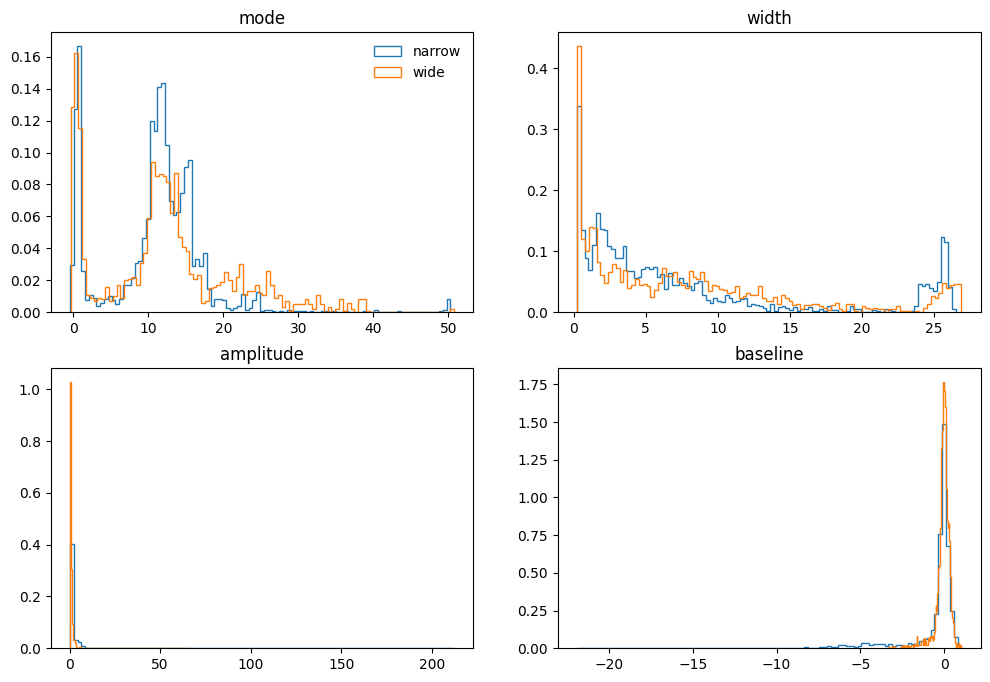

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
all_axs = axs.flatten()
for ii,par in enumerate(['mode', 'width', 'amplitude', 'baseline']):
    ax = all_axs[ii]
    #sns.histplot(dfs[('gaussian', par, 'narrow')], ax=ax, kde=True, label='Gaussian')
    ax.hist( dfs[mask_ng][('gaussian', par, 'narrow')], bins=100, histtype='step', density=True, label='narrow')
    ax.hist( dfs[mask_wg][('gaussian', par, 'wide')],   bins=100, histtype='step', density=True, label='wide' )
    ax.set_title(par)
all_axs[0].legend()
#
dfs[mask_ng][ dfs[mask_ng][('gaussian', 'baseline', 'narrow')] < 3 ][('gaussian', 'amplitude', 'narrow')].mean()

In [44]:
from scipy import odr

In [48]:
def odr_1dregression(data, x, y):
    #def f(B,x):
    #    return B[0]*x + B[1]
    #linear_model = odr.Model(f)
    dat = odr.Data(data[x], data[y])
    myodr = odr.ODR(dat, odr.unilinear, beta0=[1., 0.]) # start point = identity
    res = myodr.run()
    return res

def odr_pred(odr_res, x):
    B = odr_res.beta
    return B[0]*x + B[1]

In [54]:
res = odr_1dregression( data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) )
res.pprint()

Beta: [ 2.01798542 -7.06635165]
Beta Std Error: [0.11584281 1.06290115]
Beta Covariance: [[ 0.00055352 -0.00469897]
 [-0.00469897  0.04659979]]
Residual Variance: 24.24385944288184
Inverse Condition #: 0.004110873166098776
Reason(s) for Halting:
  Sum of squares convergence


## Mode

PearsonRResult(statistic=0.3591763044636368, pvalue=1.9472399253480736e-24)
Beta: [ 2.01798542 -7.06635165]
Beta Std Error: [0.11584281 1.06290115]
Beta Covariance: [[ 0.00055352 -0.00469897]
 [-0.00469897  0.04659979]]
Residual Variance: 24.24385944288184
Inverse Condition #: 0.004110873166098776
Reason(s) for Halting:
  Sum of squares convergence

Beta: [  2.38498474 -13.7575573 ]
Beta Std Error: [0.06614862 0.80079587]
Beta Covariance: [[ 0.00011932 -0.00136521]
 [-0.00136521  0.0174877 ]]
Residual Variance: 36.670001900762806
Inverse Condition #: 0.002686121851907729
Reason(s) for Halting:
  Sum of squares convergence


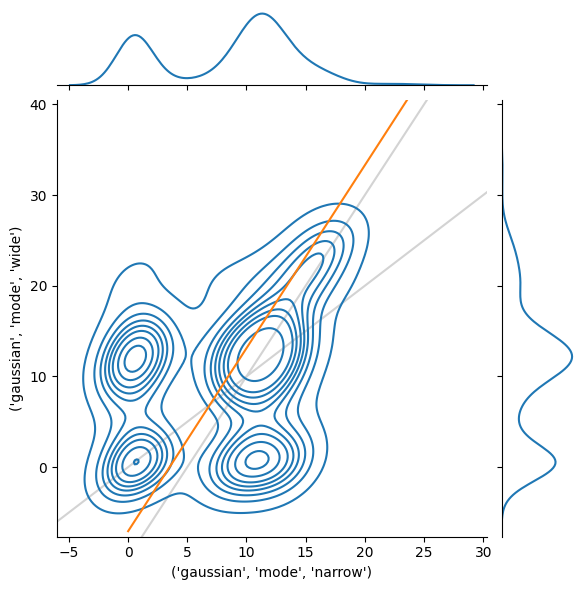

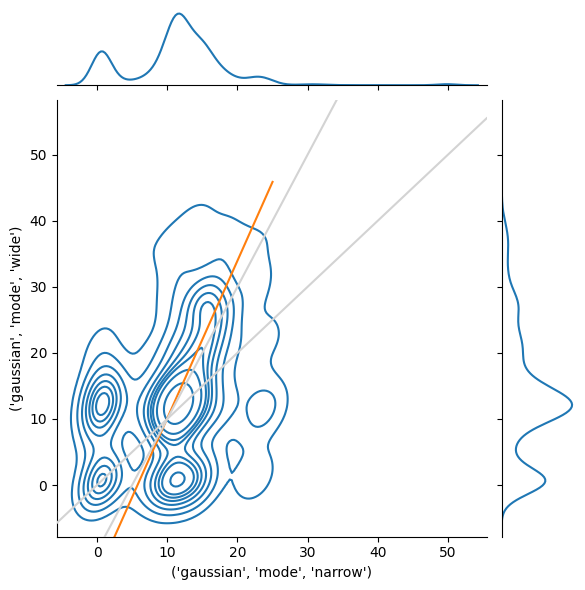

In [62]:
sns.jointplot(data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=-1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg][('gaussian', 'mode', 'narrow')], dfs[mask_bg][('gaussian', 'mode', 'wide')]) )
res = odr_1dregression( data=dfs[mask_bg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);
##
print()
sns.jointplot(data=dfs[mask_eg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', )
plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000)
stats.pearsonr(dfs[mask_eg][('gaussian', 'mode', 'narrow')], dfs[mask_eg][('gaussian', 'mode', 'wide')])
res = odr_1dregression( data=dfs[mask_eg], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);

In [63]:
res = odr_1dregression( data=dfs[mask_bg], y=('gaussian', 'mode', 'narrow'), x=('gaussian', 'mode', 'wide' ) )
res.pprint()

Beta: [0.49544526 3.50267721]
Beta Std Error: [0.02844454 0.34914192]
Beta Covariance: [[ 3.33730708e-05 -3.35890314e-04]
 [-3.35890314e-04  5.02808073e-03]]
Residual Variance: 24.24385927725785
Inverse Condition #: 0.0046537943969977
Reason(s) for Halting:
  Sum of squares convergence


In [65]:
mask_08 = (dfs[('gaussian', 'mode', 'narrow')] >=  8) & (dfs[('gaussian', 'mode', 'wide')] >=  8)
mask_10 = (dfs[('gaussian', 'mode', 'narrow')] >= 10) & (dfs[('gaussian', 'mode', 'wide')] >= 10)
mask_11 = (dfs[('gaussian', 'mode', 'narrow')] >= 11) & (dfs[('gaussian', 'mode', 'wide')] >= 11)
(mask_bg & mask_10).sum()

279

Beta: [  2.52079451 -16.74824566]
Beta Std Error: [0.14457286 1.90998241]
Beta Covariance: [[ 0.00677534 -0.08850714]
 [-0.08850714  1.18254066]]
Residual Variance: 3.084911085122124
Inverse Condition #: 0.0011229721933152343
Reason(s) for Halting:
  Sum of squares convergence
PearsonRResult(statistic=0.6831573157385459, pvalue=1.0694215021430784e-39)


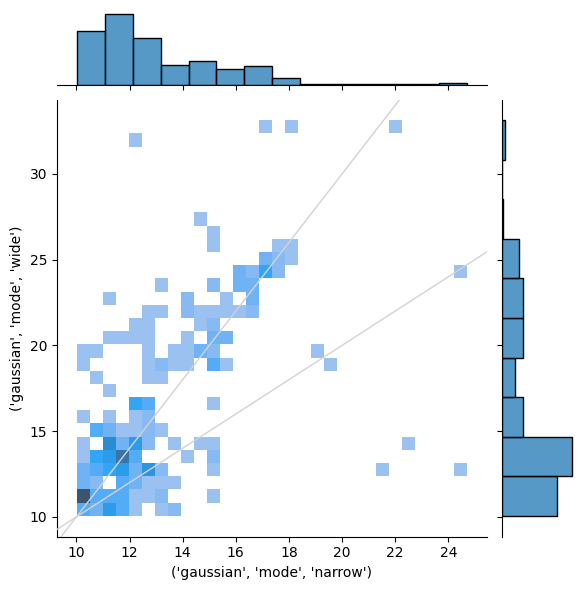

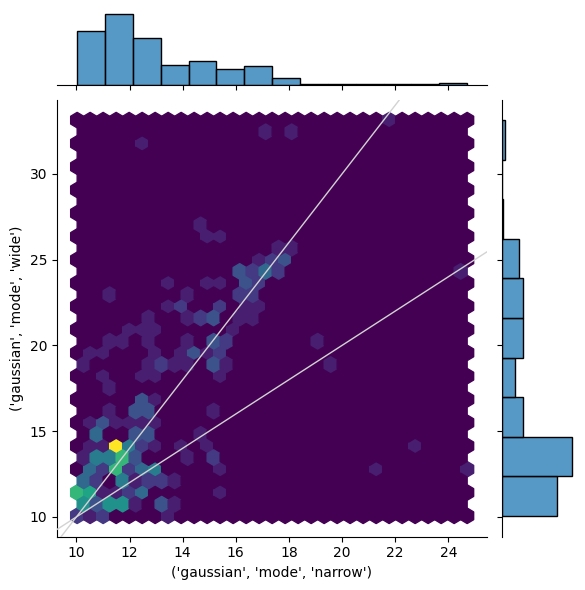

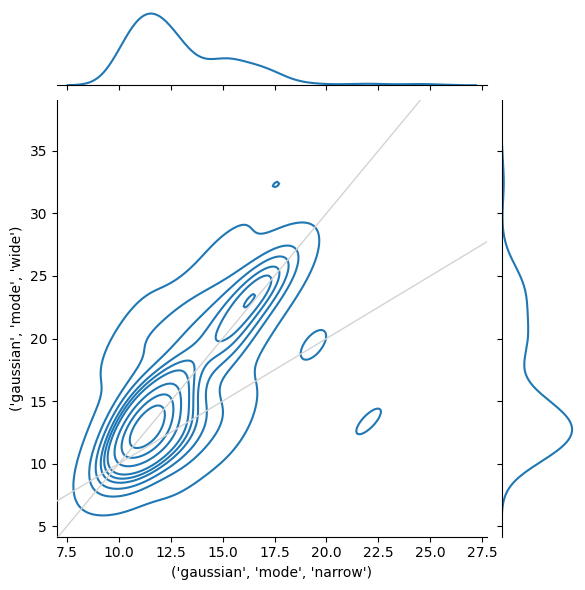

In [165]:
#sns.jointplot(data=dfs[mask_bg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='hist', bins=25) #, cmap='viridis')
res = odr_1dregression( data=dfs[mask_bg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide' ) ); res.pprint()
for kwargs in [dict(kind='hist', bins=30), dict(kind='hex', gridsize=30, cmap='viridis'), dict(kind='kde'), ]:
    sns.jointplot(data=dfs[mask_bg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), **kwargs) #, cmap='viridis')
    plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000, lw=1)
    plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000, lw=1)
    #xlm = plt.xlim(); ylm = plt.ylim()
    #plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
    #plt.xlim(*xlm); plt.ylim(*ylm);
print( stats.pearsonr(dfs[mask_bg & mask_10][('gaussian', 'mode', 'narrow')], dfs[mask_bg & mask_10][('gaussian', 'mode', 'wide')]) )

PearsonRResult(statistic=0.34432023120548494, pvalue=1.6534992145934862e-54)

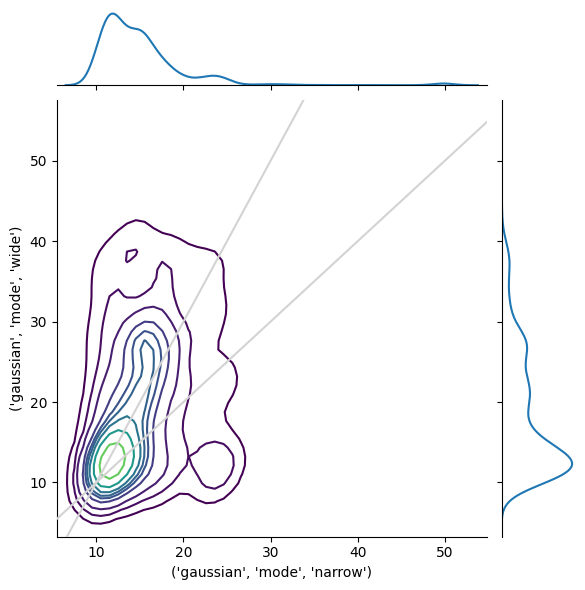

In [156]:
### same with either one good
sns.jointplot(data=dfs[mask_eg & mask_10], x=('gaussian', 'mode', 'narrow'), y=('gaussian', 'mode', 'wide'), kind='kde', gridsize=50, cmap='viridis')
plt.axline((10, 10), slope=1, color='lightgrey', zorder=1000)
plt.axline((10, 10), slope=2, color='lightgrey', zorder=1000)
stats.pearsonr(dfs[mask_eg & mask_10][('gaussian', 'mode', 'narrow')], dfs[mask_eg & mask_10][('gaussian', 'mode', 'wide')])

## Width

PearsonRResult(statistic=0.267736366530668, pvalue=5.758561668727034e-06)
Beta: [0.51692956 4.38471039]
Beta Std Error: [0.05450297 0.55915773]
Beta Covariance: [[ 7.18374658e-05 -4.65701137e-04]
 [-4.65701137e-04  7.56100037e-03]]
Residual Variance: 41.35132228150667
Inverse Condition #: 0.007564446809264631
Reason(s) for Halting:
  Sum of squares convergence


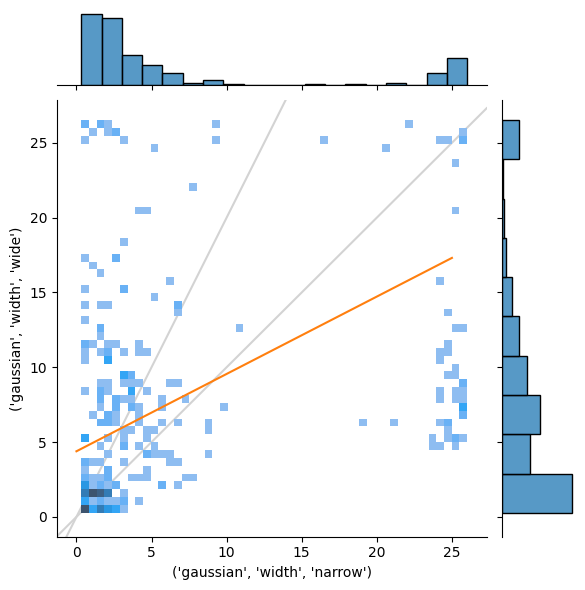

In [94]:
mask = mask_bg & mask_10
sns.jointplot(data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide'), kind='hist', bins=50 )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask][('gaussian', 'width', 'narrow')], dfs[mask][('gaussian', 'width', 'wide')]) )
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);


In [146]:
mask_wrange = (dfs[('gaussian', 'width', 'narrow')] <=  15) & (dfs[('gaussian', 'width', 'wide')] <=  30)

PearsonRResult(statistic=0.267736366530668, pvalue=5.758561668727034e-06)
Beta: [0.51692956 4.38471039]
Beta Std Error: [0.05450297 0.55915773]
Beta Covariance: [[ 7.18374658e-05 -4.65701137e-04]
 [-4.65701137e-04  7.56100037e-03]]
Residual Variance: 41.35132228150667
Inverse Condition #: 0.007564446809264631
Reason(s) for Halting:
  Sum of squares convergence


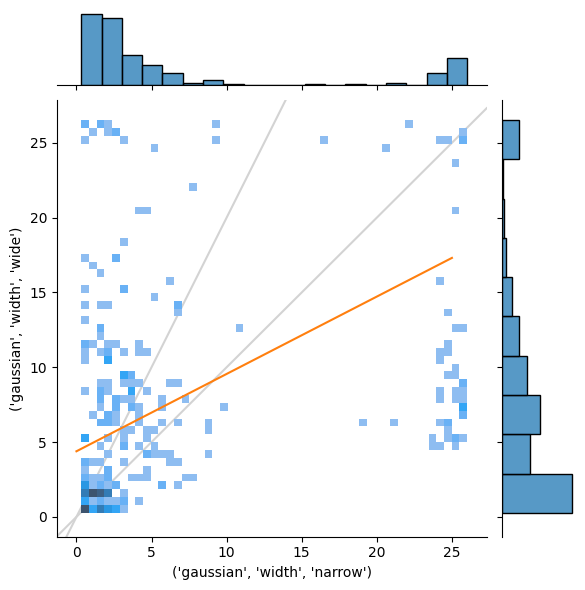

In [149]:
mask = mask_bg & mask_10 #& mask_wrange
sns.jointplot(data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide'), kind='hist', bins=50 )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask][('gaussian', 'width', 'narrow')], dfs[mask][('gaussian', 'width', 'wide')]) )
res = odr_1dregression( data=dfs[mask], x=('gaussian', 'width', 'narrow'), y=('gaussian', 'width', 'wide' ) ); res.pprint()
xlm = plt.xlim(); ylm = plt.ylim()
plt.plot( np.linspace(0,25), odr_pred(res, np.linspace(0,25)), c='C1')
plt.xlim(*xlm); plt.ylim(*ylm);


In [78]:
amp_th = 5
print( ( dfs[mask_bg][('gaussian', 'amplitude', 'narrow')] > amp_th ).mean() )
print( ( dfs[mask_bg][('gaussian', 'amplitude', 'wide')] > amp_th ).mean() )

0.03835978835978836
0.007936507936507936


PearsonRResult(statistic=0.0330370588876355, pvalue=0.36434678784619945)


PearsonRResult(statistic=0.07228437052805105, pvalue=0.05220249960718984)

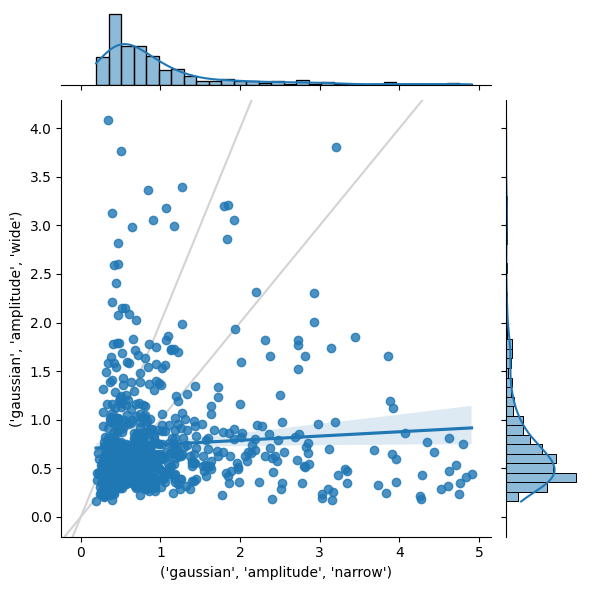

In [79]:
mask_reasonable_amp = ( dfs[mask_bg][('gaussian', 'amplitude', 'narrow')] < amp_th ) & ( dfs[mask_bg][('gaussian', 'amplitude', 'wide')] < amp_th )
sns.jointplot(data=dfs[mask_bg][mask_reasonable_amp], x=('gaussian', 'amplitude', 'narrow'), y=('gaussian', 'amplitude', 'wide'), kind='reg', )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg][('gaussian', 'amplitude', 'narrow')], dfs[mask_bg][('gaussian', 'amplitude', 'wide')]) )
stats.pearsonr(dfs[mask_bg][mask_reasonable_amp][('gaussian', 'amplitude', 'narrow')], dfs[mask_bg][mask_reasonable_amp][('gaussian', 'amplitude', 'wide')])

PearsonRResult(statistic=0.3642633495715716, pvalue=3.8919441427453215e-25)


PearsonRResult(statistic=0.4294662145125886, pvalue=9.150991863473482e-34)

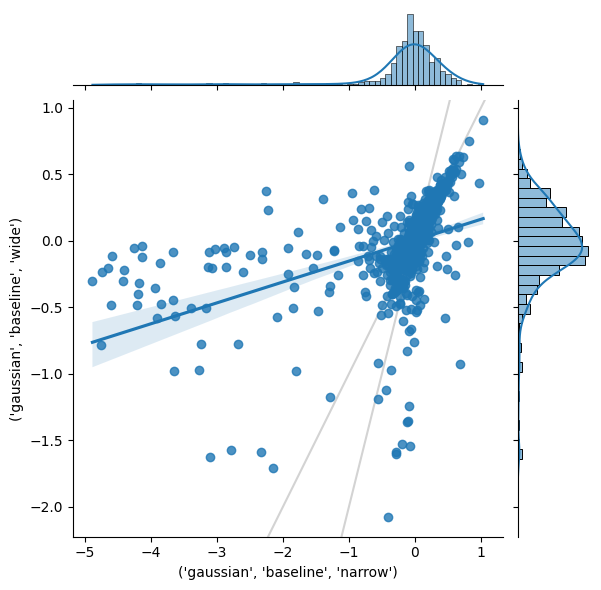

In [80]:
sns.jointplot(data=dfs[mask_bg][mask_reasonable_amp], x=('gaussian', 'baseline', 'narrow'), y=('gaussian', 'baseline', 'wide'), kind='reg', )
plt.axline((0, 0), slope=1, color='lightgrey', zorder=-1000)
plt.axline((0, 0), slope=2, color='lightgrey', zorder=-1000)
print( stats.pearsonr(dfs[mask_bg][('gaussian', 'baseline', 'narrow')], dfs[mask_bg][('gaussian', 'baseline', 'wide')]) )
stats.pearsonr(dfs[mask_bg][mask_reasonable_amp][('gaussian', 'baseline', 'narrow')], dfs[mask_bg][mask_reasonable_amp][('gaussian', 'baseline', 'wide')])

# Focus on voxels for which mode ≈ 0

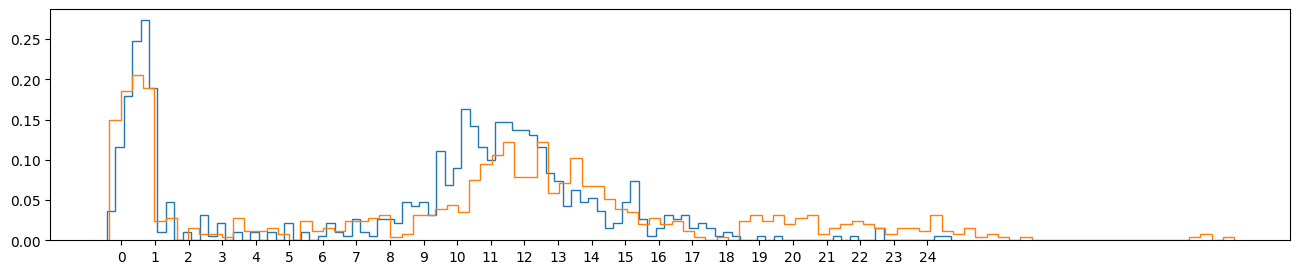

In [122]:
plt.figure(figsize=(16, 3))
plt.hist( dfs[mask_bg][('gaussian', 'mode', 'narrow')], histtype='step', bins=100, density=True, label='narrow');
plt.hist( dfs[mask_bg][('gaussian', 'mode', 'wide')], histtype='step', bins=100, density=True, label='narrow');
plt.xticks(np.arange(0, 25, 1));

In [97]:
mode_th = 1.5
mask_m0 = dfs[('gaussian', 'mode', 'narrow')].abs() < mode_th
dfs[mask_bg & mask_m0]

model           gaussian                                                                                                                                                 \
parameter           mode                                     width                                amplitude                                baseline                       
range_n             wide    narrow       both      wide2      wide     narrow      both     wide2      wide    narrow      both     wide2      wide    narrow      both   
subject voxel                                                                                                                                                             
07      737    10.626707  0.698293  10.527299  10.615285  0.402806   6.452129  1.408712  0.359772  0.893919  0.968955  0.326798  0.948433 -0.001650 -0.070816 -0.023047   
        752    13.263162  0.618514   9.401989  13.272508  1.148416   5.532659  4.848480  1.164617  0.550307  1.956657  0.299122  0.555363 -0.018924 -0.048837 -0.047175   
        759    13.248358  0.554598   9.625288  13.248182  1.192088   6.459154  4.558491  1.194987  0.558423  1.417419  0.337105  0.559909 -0.036957 -0.097006 -0.074036   
        784    13.343612  0.750963  10.452908  13.360479  1.167824   5.656386  3.726494  1.213010  0.664756  2.094755  0.344137  0.685420 -0.036609 -0.079343 -0.061261   
        812    13.308934  0.733234   8.410880  13.325021  1.093876   4.704999  5.205870  1.120423  0.509071  2.808562  0.240953  0.524785 -0.106189 -0.131893 -0.126356   
...                  ...       ...        ...        ...       ...        ...       ...       ...       ...       ...       ...       ...       ...       ...       ...   
19      641    12.665819  0.931785   1.463177  12.655403  3.498766   4.467552  7.296731  3.445076  0.667419  6.490928  1.384332  0.656698  0.299451  0.353166  0.306212   
        648    12.912380  1.332365   9.388368  12.924226  3.604351   6.307122  4.685929  3.686096  0.573410  1.633382  0.543688  0.588232  0.009452  0.006034  0.008601   
        657    12.238037  0.823294  10.441996  12.406881  3.271526   7.500922  4.175261  1.179835  0.573521  0.965423  0.441035  0.658640  0.092164  0.080136  0.089278   
        691    12.616231  0.927168   6.072388  12.307734  3.351459   4.675299  5.472484  0.981414  0.724213  5.728531  0.943647  0.908993  0.072478  0.109323  0.081172   
21      36     13.206624  0.874397  11.262132  13.031248  4.784644  12.271671  5.815486  6.959484  0.392146  0.518803  0.321406  0.533734 -0.292606 -0.372465 -0.299021   

model                                                                                                    lognormal                                                       \
parameter                      r2                                    cvr2                                     mode                                     width              
range_n           wide2      wide    narrow      both     wide2      wide    narrow      both     wide2       wide    narrow       both      wide2      wide     narrow   
subject voxel                                                                                                                                                             
07      737    0.044993  0.073189  0.047746  0.045119  0.102560  0.011496  0.018303  0.022951 -0.036542  10.596643  1.000000   1.057483  10.585808  0.884671   2.787879   
        752   -0.025549  0.066163  0.046402  0.032449  0.106567  0.019848  0.023687  0.000814 -0.024674  13.154997  1.053708  10.366319  13.166619  2.646612   2.238512   
        759   -0.038492  0.072789  0.052943  0.041635  0.110490  0.028603  0.029867  0.016956  0.001019  13.150517  1.410901  10.578399  13.152524  2.761500   3.342043   
        784   -0.061208  0.070600  0.048410  0.034221  0.123058  0.021040  0.031352  0.004614  0.038194  13.236061  0.958775  10.679045  13.255372  2.707010   2.153829   
        812   -0.121691  0.053325  0.036453  0.019349  0.100188  0

In [98]:
dfs[mask_bg & mask_m0].index.get_level_values('subject').unique()

Index(['07', '08', '09', '12', '13', '15', '16', '17', '19', '21'], dtype='object', name='subject')

In [99]:
dfs[mask_bg & mask_m0].loc['07'].index

Index([737, 752, 759, 784, 812, 813], dtype='int64', name='voxel')

2024-05-29 17:08:52.322700: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


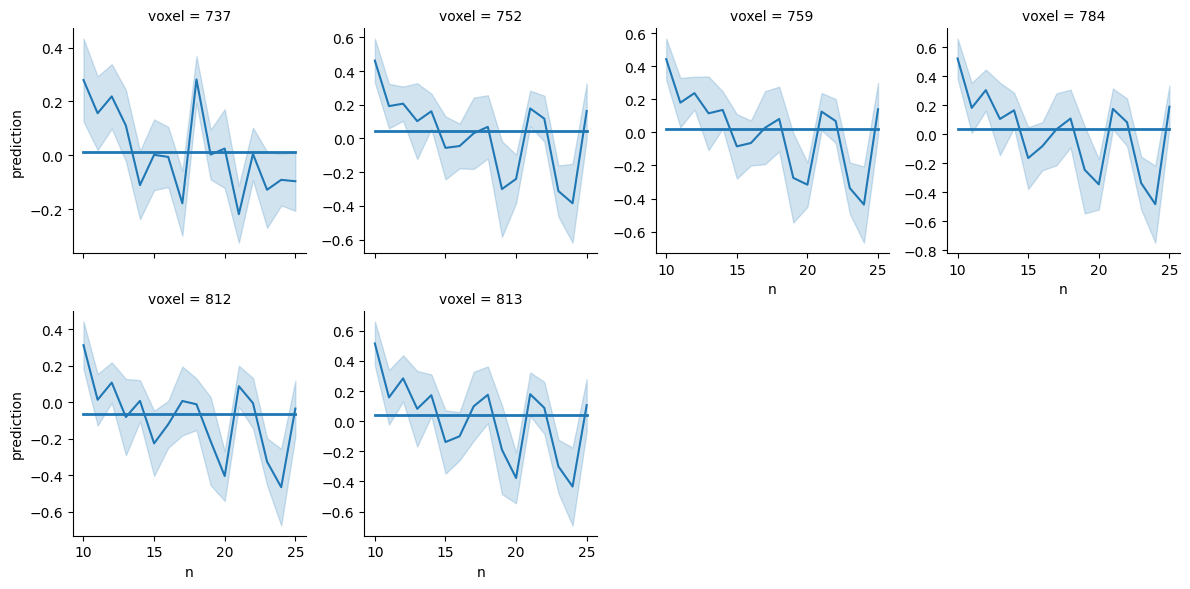

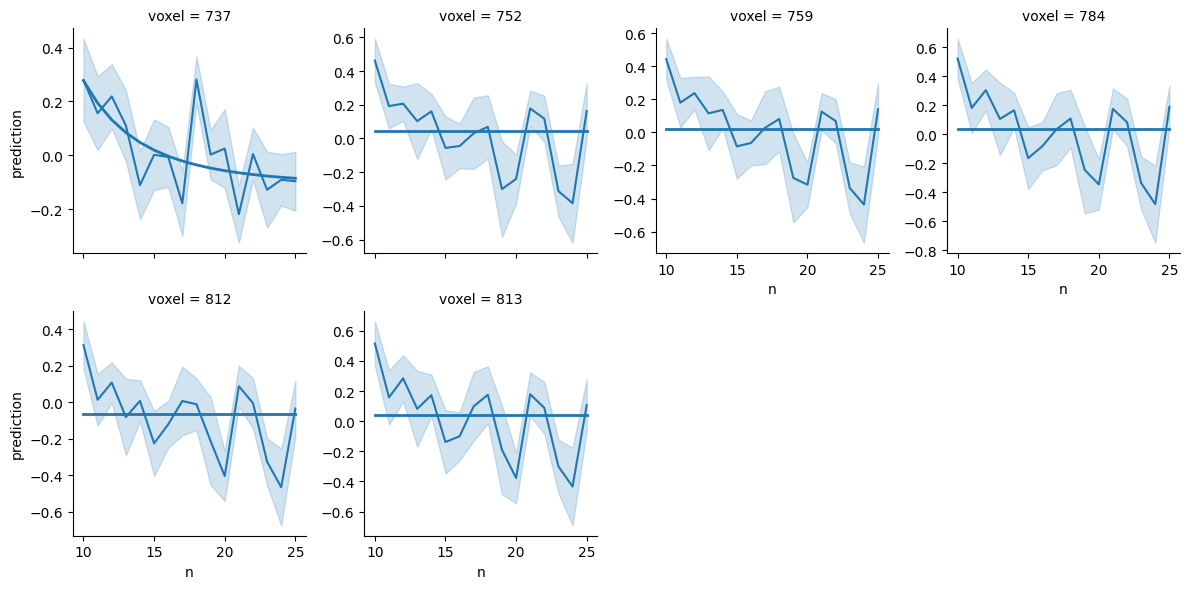

In [100]:
plot_prf_predictions('07', bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc['07'].index, gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions('07', bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc['07'].index, gaussian=False, range_n='narrow', smoothed=True)

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/neural_priors/utils/plotting.py:54: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  result = result.unstack('voxel').loc[:, (slice(None), voxels)].stack('voxel')


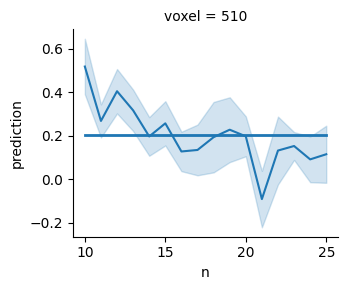

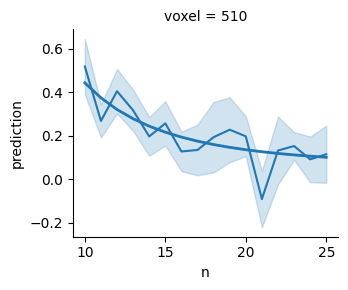

In [101]:
subject = '08'
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=False, range_n='narrow', smoothed=True)

In [102]:
subject = '12'
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=True, range_n='narrow', smoothed=True)
plot_prf_predictions(subject, bids_folder=bids_folder, voxels=dfs[mask_bg & mask_m0].loc[subject].index, gaussian=False, range_n='narrow', smoothed=True)

ValueError: File not found: '../../ds-neuralpriors/derivatives/ips_masks/sub-12/anat/sub-12_space-T1w_desc-NPCr_mask.nii.gz'

## Ideal tuning curves

In [119]:
import apc_utils as apc

Text(0.5, 0, 'Number')

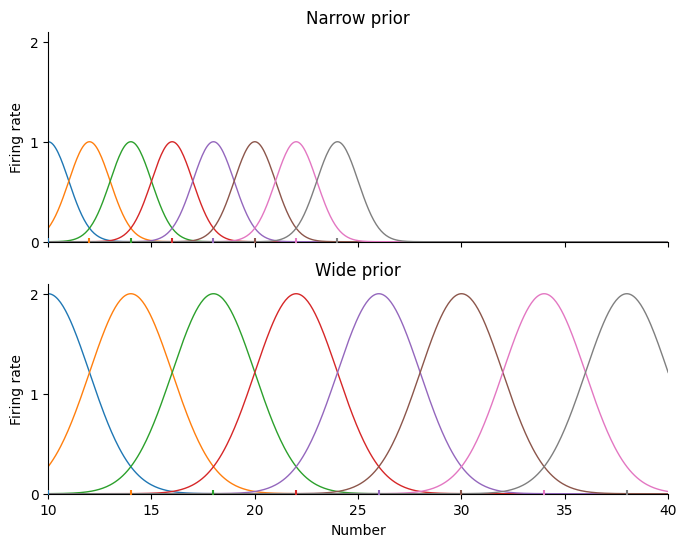

In [141]:
def norm(x, mu, w):
    return np.exp(-.5*((x-mu)/w)**2)
fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True, sharey=True)
sigma = 1
xx = np.linspace(10, 40, 500)
for mode in np.arange(10, 25, 2):
    axs[0].plot(xx, norm(xx, mode, sigma), lw=1)
    axs[0].scatter(x=mode, y=0, zorder=1000, marker='|')
    mode_w = 10 + 2*(mode-10)
    sigma_w = 2*sigma
    axs[1].plot(xx, 2*norm(xx, mode_w, sigma_w), lw=1)
    axs[1].scatter(x=mode_w, y=0, zorder=1000, marker='|')
for ax in axs:
    apc.removeAxSpines(ax)
    ax.set_yticks([0,1,2])
    ax.set_ylim(0,None); ax.set_xlim(10,40)
    ax.set_ylabel('Firing rate')
axs[0].set_title('Narrow prior')
axs[1].set_title('Wide prior')
axs[1].set_xlabel('Number')

In [ ]:
# shift -> local FI divided by 2, total FI equal
# width x 2 -> local FI divided by 4, 